In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm

# Get the parent folder path (folder K)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_folder)

# Add folder A to the Python path
folder_classes_path = os.path.join(parent_folder, 'classes')
sys.path.append(folder_classes_path)

c:\Users\Zeyi\Documents\GitHub\WB_Algo\Stochastic_FP


Load all necessary classes and functions.

In [2]:
from true_WB import *
from entropic_estimate_OT import *
from entropic_iterative_scheme import *
from config_log import *
from measure_visualize import *
from input_generate_entropy import *
from sample_plot import *

Set the parameters.

In [3]:
dim = 2
# dim = 10
num_samples = 5000
num_measures = 5
iter = 0
truncated_radius = 100
seed = 1009

Construct the source_sampler (i.e., the sampler for the ground-truth Wasserstein barycenter). In particular, we consider uniform mixture of 5 Gaussians, and the seed is tuned as 1009 to make the distribution "fancy" (see input_measure_select).

In [4]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.random_components(num_components=5, uniform_weights = True, seed = seed) # seed from the measure selection
source_sampler.set_truncation(truncated_radius)

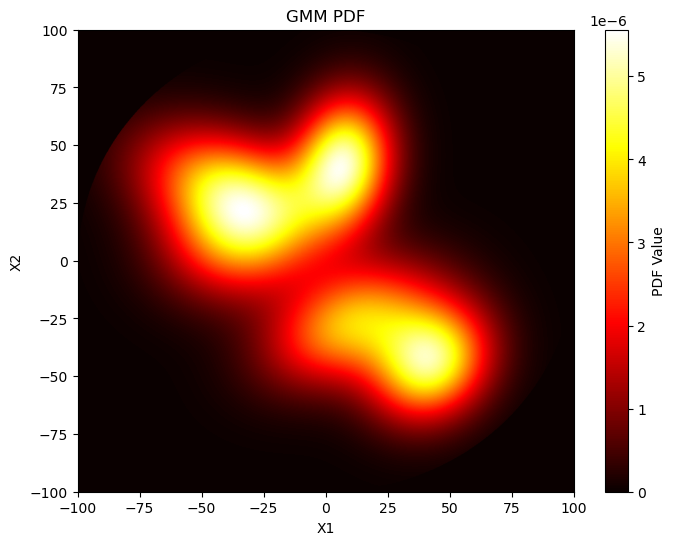

In [5]:
plot_2d_gmm_pdf(source_sampler, truncated_radius, save_path = None)

We now construct tilde_K auxiliary measures as the input to our entropic sampler. These measures are used to provide g and Y for the mappings.

In [6]:
auxiliary_measure_sampler_set = []
for auxiliary_seed in [1010, 1018, 1014, 1016, 1003]:
    auxiliary_measure_sampler = MixtureOfGaussians(dim)
    auxiliary_measure_sampler.random_components(num_components=5, uniform_weights = True, seed = auxiliary_seed)
    auxiliary_measure_sampler.set_truncation(truncated_radius)
    auxiliary_measure_sampler_set.append(auxiliary_measure_sampler)

In [7]:
# auxiliary_0_samples = auxiliary_measure_sampler_set[0].sample(500, multiplication_factor = 1)
# plot_2d_source_measures_kde(auxiliary_0_samples, plot_dirc = None, scatter = False)

In [8]:
# construct entropic_sampler
entropic_sampler = entropic_input_sampler(dim, num_measures, auxiliary_measure_sampler_set, source_sampler = source_sampler, n_k = 1000, seed = 120)

In [9]:
# generate strong convexity parameters of the mappings.
entropic_sampler.generate_strong_convexity_param()
print("strong convexity parameters all set.")

strong convexity parameters all set.


In [10]:
# assign theta
entropic_sampler.assign_theta()
print("theta all set.")

theta all set.


In [11]:
# generate Y matrices
entropic_sampler.generate_Y_matrices()
print("Y matrices all set.")

source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 6228.14it/s]


Finished generating Y matrix for auxiliary measure 0


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 5356.14it/s]


Finished generating Y matrix for auxiliary measure 1


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 7236.47it/s]


Finished generating Y matrix for auxiliary measure 2


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 6131.37it/s]


Finished generating Y matrix for auxiliary measure 3


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 6006.27it/s]

Finished generating Y matrix for auxiliary measure 4
Y matrices all set.


In [12]:
import jax
jax.config.update("jax_enable_x64", True)

# generate g vectors
entropic_sampler.generate_g_vectors()
print("g vectors all set.")


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 5580.72it/s]


Finished generating g vector for auxiliary measure 0
Finished generating g vector for auxiliary measure 1
Finished generating g vector for auxiliary measure 2
Finished generating g vector for auxiliary measure 3
Finished generating g vector for auxiliary measure 4
g vectors all set.


In [13]:
# generate smoothness parameters; this involves solving max eigen for each tilde_k
entropic_sampler.generate_smoothness_param()
print("smoothness parameters all set.")


tilde_k: 0: 100%|██████████| 200/200 [11:27<00:00,  3.44s/it]


max eigenvalue for 0: 1639.8110853146632.


tilde_k: 1: 100%|██████████| 200/200 [07:12<00:00,  2.16s/it]


max eigenvalue for 1: 1087.9610059355505.


tilde_k: 2: 100%|██████████| 200/200 [08:20<00:00,  2.50s/it]


max eigenvalue for 2: 510.008974388025.


tilde_k: 3: 100%|██████████| 200/200 [12:27<00:00,  3.74s/it]


max eigenvalue for 3: 410.6497267699318.


tilde_k: 4: 100%|██████████| 200/200 [07:59<00:00,  2.40s/it]

max eigenvalue for 4: 646.2997193032386.
smoothness parameters all set.


In [14]:
print(entropic_sampler.smoothness_param_dict)

{0: 163.9811085314663, 1: 108.79610059355505, 2: 51.000897438802504, 3: 41.06497267699318, 4: 64.62997193032386}


In [15]:
# construct a surjective mapping to map component maps to their respective OT maps for generating input measures.
entropic_sampler.construct_surjective_mapping()
print("surjective mapping all set.")


surjective mapping all set.


In [16]:
# generate A matrices
entropic_sampler.generate_A_matrices()
print("A matrices all set.")


The V_value record is [495.77735151544147, 18.31888434839084, 18.318780204363975, 18.318780186456024].
A matrices all set.


### Reverse engineer for well-structured input measures.

In [17]:
for key, value in entropic_sampler.surjective_mapping.items():
    print(key, ' : ', value)

# print g_vector_dict
for key, value in entropic_sampler.g_vector_dict.items():
    print(key, ' : ', value[:10])

# impose entropic_sampler.theta_dict to be all with value 0.5
entropic_sampler.theta_dict = {key: 0.5 for key in entropic_sampler.theta_dict.keys()}

for key, value in entropic_sampler.theta_dict.items():
    print(key, ' : ', value)


0  :  2
1  :  1
2  :  3
3  :  0
4  :  3
5  :  0
6  :  2
7  :  0
8  :  4
9  :  1
0  :  [ 3404.5157191     73.75391287  4590.32469711 -2458.82020983
 -3343.64919407  2841.58196332   681.19799818  3723.84974965
 -1194.3469167   2200.70490631]
1  :  [-1943.24167043  4065.29617151  2704.31973322 -1050.30009511
   867.9787251   2048.15725323    67.14784009 -1631.20249647
  1853.12952919  2431.65781971]
2  :  [ -755.50263951  3490.23775623  1463.28694456  -641.58547345
   389.15798945 -4306.84848453  1242.03727239 -2310.97510081
  -138.0113183    903.35315687]
3  :  [ -751.41528056  1553.20267401  1253.14832519 -1692.26510995
  -434.77871923  -219.56506698 -1822.87921772 -2154.8683027
  1285.3097059  -1527.75504221]
4  :  [ -327.12562147   608.53142623  2262.9956164  -2632.26425161
   919.42016529   286.48937652  -969.02959759 -3122.67012593
 -3839.99665627   565.84850738]
0  :  0.5
1  :  0.5
2  :  0.5
3  :  0.5
4  :  0.5


In [18]:
A_matrices_dict = entropic_sampler.A_matrices_dict
sum_matrix = np.zeros((dim, dim))
for i in range(num_measures):
    sum_matrix += A_matrices_dict[i]
print(f"The sum of the matrices is {sum_matrix}.")

The sum of the matrices is [[5.00000036e+00 5.28365004e-08]
 [5.28365008e-08 4.99999959e+00]].


In [67]:
tilde_K = entropic_sampler.tilde_K
sample_size = 1000
batch_sample_collection = {k: [] for k in range(num_measures)}
candidate_sample_collection = {k: [] for k in range(2 * tilde_K)}

source_samples = source_sampler.sample(sample_size, multiplication_factor = 1)
# measure_samples = self.generate_input_measure_sample(source_samples[0])

for i in tqdm(range(sample_size), desc= f"Generating {sample_size} input measure samples"):
    x = source_samples[i]
    measure_samples_dict, candidate_map_dict = entropic_sampler.generate_input_measure_sample(x, gamma = 0.5) # a dictionary with k keys
    for k in range(num_measures):
        batch_sample_collection[k].append(measure_samples_dict[k])
    for k in range(2 * tilde_K):
        candidate_sample_collection[k].append(candidate_map_dict[k])

Generating 1000 input measure samples: 100%|██████████| 1000/1000 [00:03<00:00, 254.39it/s]


In [68]:
lambda_list = []
for i in range(tilde_K):
    lambda_list.append(entropic_sampler.smoothness_param_dict[i])
lambda_list

[91.28243289523436,
 202.25870948704318,
 120.89613186313049,
 40.376628053416184,
 102.59304369545366]

In [82]:
gamma = 0.5
alpha_4 = 5 * (1 - gamma) / (3* lambda_list[4])
print(alpha_4)

0.008122707966507693


In [83]:
add_on_matrix = np.array([[0, 0.8], [0.8, 0]])

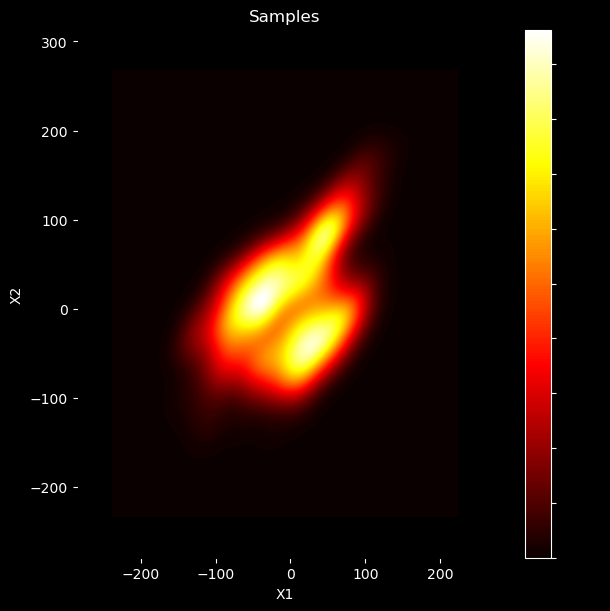

In [84]:
# source_samples = source_sampler.sample(sample_size, multiplication_factor = 1)
A_matrices_dict = entropic_sampler.A_matrices_dict
sample_combine = 0 * np.array(candidate_sample_collection[1]) + alpha_4 * np.array(candidate_sample_collection[9])
T1_sample = sample_combine + gamma * source_samples @ (A_matrices_dict[0] + A_matrices_dict[4] + 2 * add_on_matrix) 
# check
# print(T1_sample - batch_sample_collection[1])
plot_2d_source_measures_kde(T1_sample, plot_dirc = None, scatter = False)

[[ 11.41426275   3.85472329]
 [-20.9917486   34.44184412]
 [ -7.26117844  35.86816174]
 ...
 [  0.73884245  41.0627997 ]
 [-39.38552121  -8.50302167]
 [  0.49583953  55.77608372]]


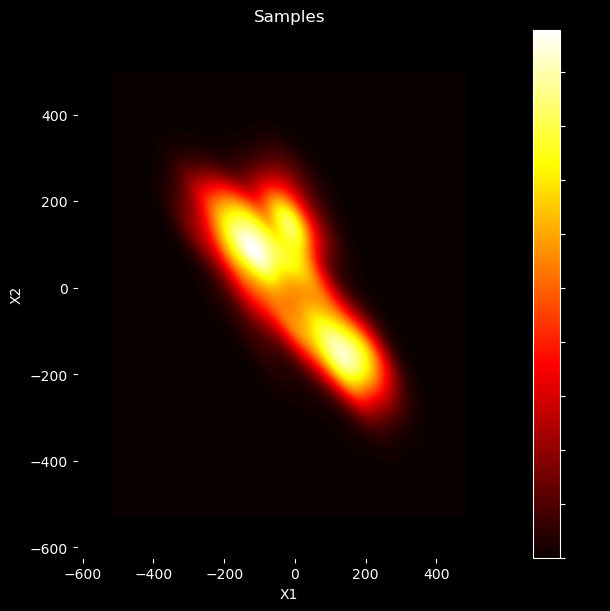

In [85]:
alpha_2 = 5 * (1 - gamma) / (3* lambda_list[2])
alpha_3 = 5 * (1 - gamma) / (3* lambda_list[3])
sample_combine = 0 * np.array(candidate_sample_collection[3]) + alpha_2 * np.array(candidate_sample_collection[5]) + alpha_3 * np.array(candidate_sample_collection[7])
# source_samples = source_sampler.sample(sample_size, multiplication_factor = 1)
T0_sample = sample_combine + gamma * source_samples @ (A_matrices_dict[3] + A_matrices_dict[1]+ A_matrices_dict[2] - 2 * add_on_matrix)
# check
print(T0_sample - batch_sample_collection[0])
plot_2d_source_measures_kde(T0_sample, plot_dirc = None, scatter = False)

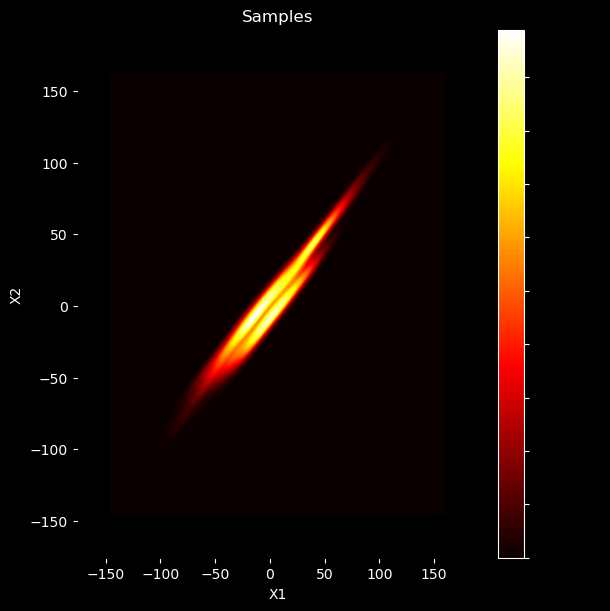

In [88]:
add_on_matrix = np.array([[0, 0.8], [0.8, 0]])
matrix_transform_1 = gamma * source_samples @ (A_matrices_dict[0] + A_matrices_dict[4] + 2 * add_on_matrix) 
plot_2d_source_measures_kde(matrix_transform_1, plot_dirc = None, scatter = False)


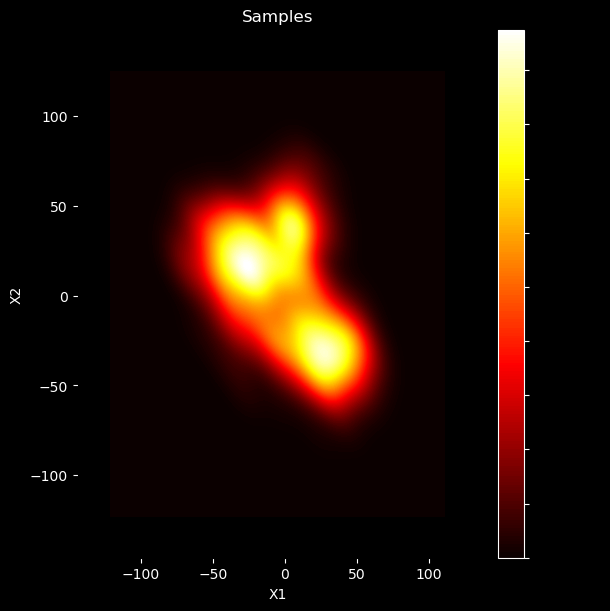

In [89]:
sample_combine = 0 * np.array(candidate_sample_collection[1]) + alpha_4 * np.array(candidate_sample_collection[9])
plot_2d_source_measures_kde(sample_combine, plot_dirc = None, scatter = False)

In [58]:
# print all A matrices
for key, value in A_matrices_dict.items():
    print(key, ' : ', value)

0  :  [[ 0.83537197 -0.03716279]
 [-0.03716279  0.87592173]]
1  :  [[ 1.02832775 -0.05693294]
 [-0.05693294  0.9036258 ]]
2  :  [[1.13590171 0.24485292]
 [0.24485292 1.19892368]]
3  :  [[ 1.04373935 -0.09721359]
 [-0.09721359  1.18114576]]
4  :  [[ 0.95665958 -0.05354355]
 [-0.05354355  0.84038263]]


In [87]:
# extract each A matrix by add_on_matrix
# print corresponding eigenvalues
add_on_matrix = np.array([[0, 0.8], [0.8, 0]])
for key, value in A_matrices_dict.items():
    print(key, ' : ', np.linalg.eig(value + add_on_matrix)[0])
for key, value in A_matrices_dict.items():
    print(key, ' : ', np.linalg.eig(value - add_on_matrix)[0])

0  :  [0.09254025 1.61875345]
1  :  [1.71165519 0.22029836]
2  :  [0.12208472 2.21274066]
3  :  [0.40630597 1.81857914]
4  :  [1.64723821 0.14980399]
0  :  [0.01823858 1.69305511]
1  :  [1.82517507 0.10677848]
2  :  [0.61137203 1.72345336]
3  :  [0.21260238 2.01228274]
4  :  [1.75404239 0.04299981]


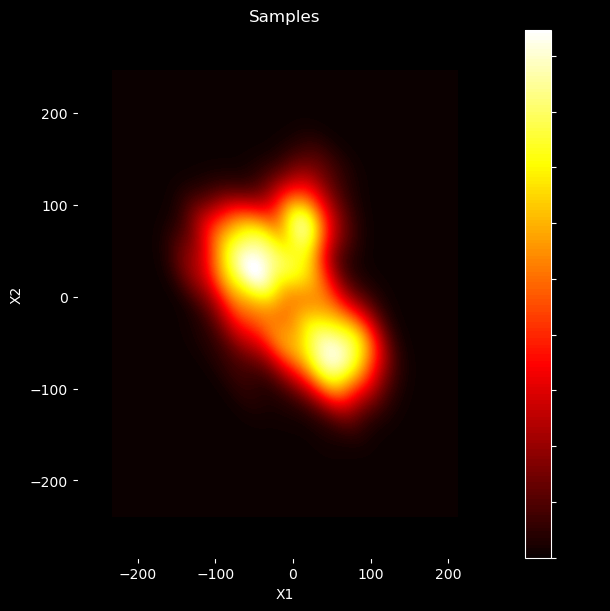

In [90]:

matrix_transform_0 = gamma * source_samples @ (A_matrices_dict[3] + A_matrices_dict[1]+ A_matrices_dict[2])
plot_2d_source_measures_kde(matrix_transform_0, plot_dirc = None, scatter = False)

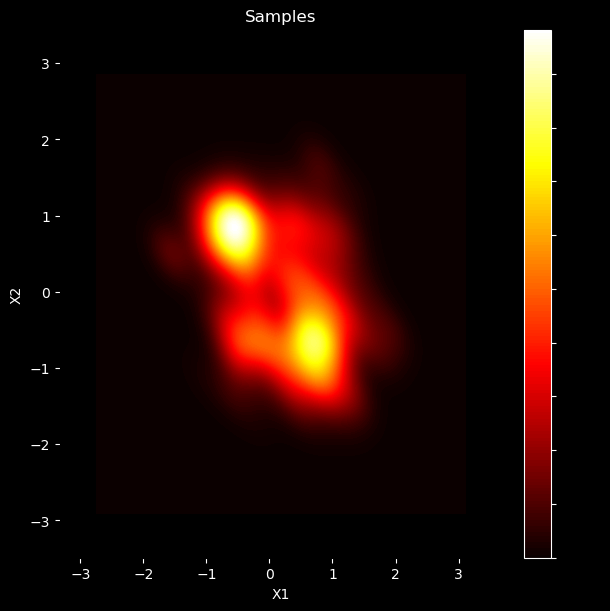

In [91]:
T_2_sample = alpha_3 * np.array(candidate_sample_collection[6])
plot_2d_source_measures_kde(T_2_sample, plot_dirc = None, scatter = False)

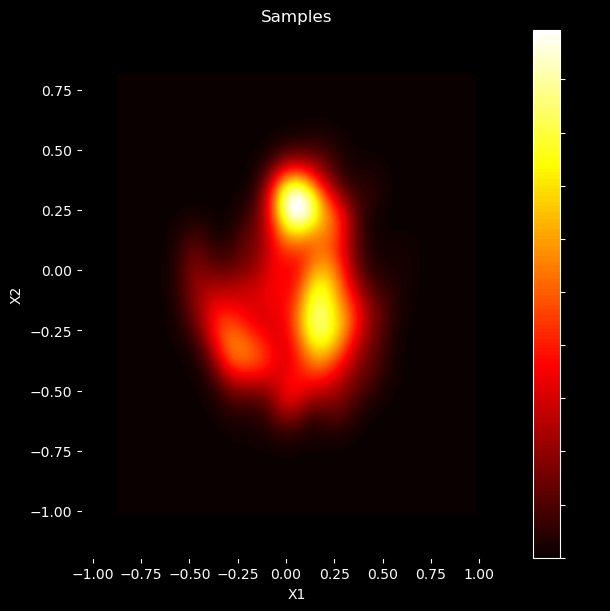

In [92]:
T_3_sample = alpha_2* np.array(candidate_sample_collection[4])
plot_2d_source_measures_kde(T_3_sample, plot_dirc = None, scatter = False)

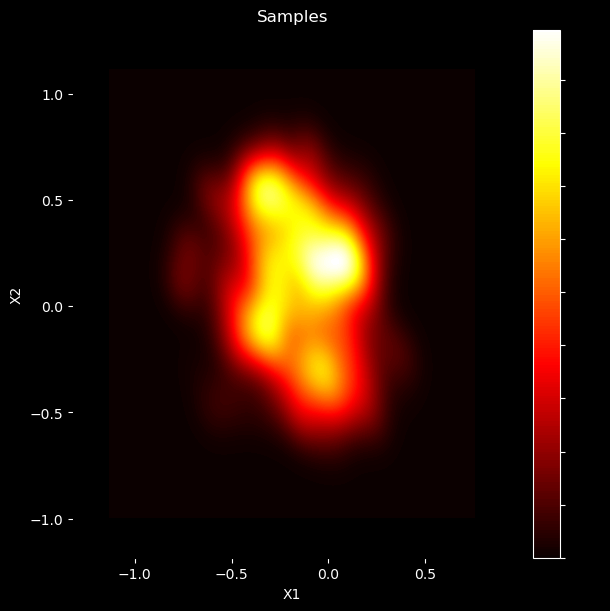

In [93]:
T_4_sample = alpha_4 * np.array(candidate_sample_collection[8])
plot_2d_source_measures_kde(T_4_sample, plot_dirc = None, scatter = False)

### Setting over. ALgorithm starts.

### Generate input measures

In [46]:
epsilon = 10 # the entropic parameter used in the iterative scheme.
num_samples = 5000

In [47]:
result_dir = "results"
os.makedirs(result_dir, exist_ok=True)
save_pathname = f"{result_dir}/entropic_measures_{num_measures}_seed_{seed}_samples_{num_samples}_dim_{dim}_epsilon_{epsilon}"

In [48]:
iterative_computer = entropic_iterative_scheme(dim, 
                             num_measures, 
                             source_sampler, 
                             entropic_sampler, 
                             source_sampler_seed = 1009,
                             log = True)

source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 10398.57it/s]


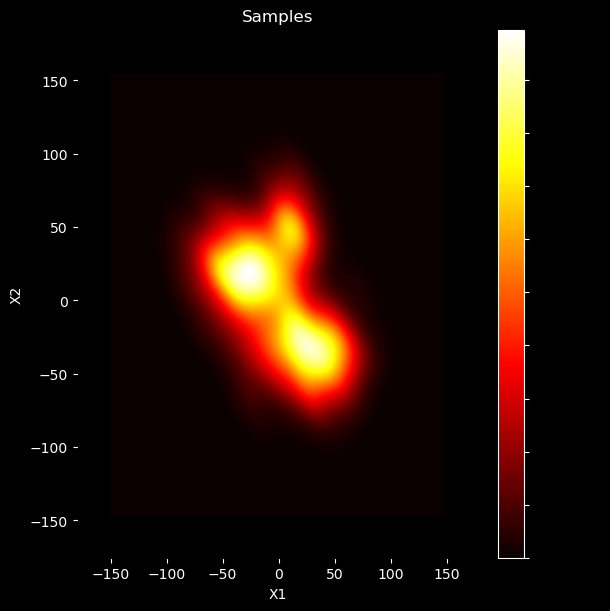

In [49]:
source_measure_samples = source_sampler.sample(1000, multiplication_factor=1)
plot_2d_source_measures_kde(source_measure_samples, plot_dirc = None, scatter = False)

In [50]:
# source and input measures visualization
plot_dirc = f"{save_pathname}/plots"
os.makedirs(plot_dirc, exist_ok=True)

visualize_num_samples = 1000

source_measure_samples = source_sampler.sample(visualize_num_samples, multiplication_factor=1)
print("Start to plot the source measure")
plot_2d_source_measures_kde(source_measure_samples, plot_dirc = plot_dirc, scatter = False)
print("Finish plotting the input measures")

input_measure_samples = entropic_sampler.sample(visualize_num_samples, gamma = 0.5, manual = True)
for measure_index in range(num_measures):
    measure_samples = np.array(input_measure_samples[measure_index])
    print(f"Start to plot the input measure {measure_index}")
    plot_2d_input_measure_kde(measure_samples, measure_index, scatter = False, plot_dirc = plot_dirc)
    print(f"Finish plotting the input measure {measure_index}")

iterative_computer.V_value_compute(source_measure_samples, input_measure_samples, iter = None, save_pathname = save_pathname)


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 10529.85it/s]


Start to plot the source measure
Finish plotting the input measures


Generating 1000 input measure samples: 100%|██████████| 1000/1000 [00:02<00:00, 338.48it/s]


Start to plot the input measure 0
Finish plotting the input measure 0
Start to plot the input measure 1
Finish plotting the input measure 1
Start to plot the input measure 2
Finish plotting the input measure 2
Start to plot the input measure 3
Finish plotting the input measure 3
Start to plot the input measure 4
Finish plotting the input measure 4


### Start the iterative scheme


In [51]:
iterative_computer.converge(iter, num_samples, max_iter=10, epsilon = epsilon, plot = True, scatter = False)

Generating 5000 input measure samples: 100%|██████████| 5000/5000 [00:16<00:00, 302.01it/s]
sampling from the pushforward measure at iteration_0: 100%|██████████| 5000/5000 [00:00<00:00, 10258.75it/s]
100%|██████████| 5/5 [00:23<00:00,  4.75s/it]
sampling from the pushforward measure at iteration_1: 100%|██████████| 5000/5000 [00:29<00:00, 169.00it/s]
100%|██████████| 5/5 [05:25<00:00, 65.17s/it] 
sampling from the pushforward measure at iteration_2: 100%|██████████| 5000/5000 [00:52<00:00, 94.37it/s] 
100%|██████████| 5/5 [05:11<00:00, 62.39s/it] 
sampling from the pushforward measure at iteration_3: 100%|██████████| 5000/5000 [01:37<00:00, 51.16it/s]
100%|██████████| 5/5 [04:57<00:00, 59.47s/it] 
sampling from the pushforward measure at iteration_4: 100%|██████████| 5000/5000 [01:16<00:00, 65.70it/s]
100%|██████████| 5/5 [05:21<00:00, 64.29s/it] 
sampling from the pushforward measure at iteration_5: 100%|██████████| 5000/5000 [01:36<00:00, 51.62it/s]
100%|██████████| 5/5 [05:21<00:00